In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy as sy
import scipy.stats
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy import ndimage
import PIL.Image
import math
import os
import string

import sys
path=r'C:\Users\31649\Documents\genome analysis\genome_topology\functions'
sys.path.append(path)


from statistical_analysis import correlate
from statistical_analysis import comparison_distributions
from math_tools import lin_fit
from math_tools import line
from plotting_tools import set_layout
from plotting_tools import save_figures
from matrix_analysis import Select_entangled_fraction
from matrix_analysis import length_L_pattern
from matrix_analysis import read_topology_matrix


In [2]:
def CreateDf_SegmentComparison(dataframe, method):
    df_plot={'Sample':dataframe['Sample'], 'Chr ID':dataframe['Chr ID'], 'Selection':dataframe[method]}
    df_plot=pd.DataFrame(data=df_plot)
    return df_plot

def Plot_SegmentComparison(df_segment_comparison, segments, clustering = None):
    cell = df_segment_comparison.columns[0]
    chrID= df_segment_comparison.columns[1]
    selection = df_segment_comparison.columns[2]
    df_segment_comparison=df_segment_comparison.pivot(cell, chrID, selection)
    
    #Reorder chromosomes
    columns =  df_segment_comparison.columns
    cols = list(columns[0]) + list(columns[11])+ list(columns[-8:-1])+list(columns[1:11]) + list(columns[12:15]) + list(columns[-1])
    df_segment_comparison = df_segment_comparison[cols]
    
    g = plt.figure(figsize = (10, 2.7))
    cmap = sns.color_palette("icefire", as_cmap=True)
    ax= sns.heatmap(df_segment_comparison, cbar_kws={'label': 'Segment'}, cmap = cmap)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(segments)
    
    if clustering:
        plt.title('L loops local {}, {}'.format(method[-6:].lower(), clustering))
    else:
        plt.title('L loops local {}'.format(method[-6:].lower()))
        
    plt.tight_layout()
    return g, columns


## Barcode analysis
Here we import matrices from chromosome segments and analyze the L pattern content, to plot individual chromosome barcodes and visualize the local distribution of the length of the L patterns. We identify the chromosome segments containing minimal and maximal L pattern length.

Pick the number of segments in which you have divided your chromosomes previously (available: 4 and 8 segments)

In [3]:
resolution = '40'
thresh = 0.99
n_segments=4
path_matrices = f'results counts/matrices/local matrices/{resolution}/{n_segments} segments'
samples = ['Control1', 'Control2', 'Treated1', 'Treated2']

chromosomes = [str(t) for t in range(1,23)]
chromosomes.append('X')


Read matrices and make L pattern dataframe

In [4]:

df_tot=pd.DataFrame()


for sample in samples:
    print(sample)
    df = pd.DataFrame()
    

    n_contacts = []
    length_tot = []
    mean = []
    sum_loops = []
    Chr_ID = []
    segment = []
    
    for chrom in chromosomes:
        print(chrom)
        for t in range(n_segments):
            
            try:
                matrix = read_topology_matrix(f'{path_matrices}/{chrom}_{sample}_{t}.feather')
                imarray = Select_entangled_fraction(np.copy(matrix))
                length=length_L_pattern(imarray)
                size=imarray.shape[0]
            
                length=length[length!=0.]
            
                if (len(length) == 0):
                    print('ERROR WARNING: Empty length')
                    length_tot.append(0)
                    mean.append(0)
                    sum_loops.append(0)
                    n_contacts.append(0)
                
                else:
                  
                    length_tot.append(length) 
                    mean.append(np.mean(length))
                    sum_loops.append(np.sum(length))
                    n_contacts.append(size)
                    
            except:
                print('ERROR WARNING: Empty matrix')
                length_tot.append(0)
                mean.append(0)
                sum_loops.append(0)
                n_contacts.append(0)
            
            segment.append(t)
            Chr_ID.append(chrom)
            
    length_tot=tuple(length_tot)  
    mean = tuple(mean)
    df['length']=pd.Series(length_tot)  
    df['n contacts']= pd.Series(n_contacts)
    df['Mean'] = pd.Series(mean)
    df['Sum'] = pd.Series(sum_loops)
    
    df['Chr ID']=pd.Series(Chr_ID)
    df['Segment']=pd.Series(segment)
    df['Sample'] = pd.Series([sample]* len(df))
    
    frames = [df_tot, df]
    df_tot = pd.concat(frames)

    
#Save L-pattern dataframe    
path_results = f'results counts/matrices/local matrices/{resolution}/{n_segments} segments/dataframe'
df_tot.to_csv(f'{path_results}/Segments.csv')

Control1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X
Control2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X
Treated1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X
Treated2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
ERROR WARNING: Empty matrix
X


Visualize the barcode for L pattern length, for all chromosomes, all samples. Choose if you want to see the 'Mean' or the 'Sum' of the L-pattern length

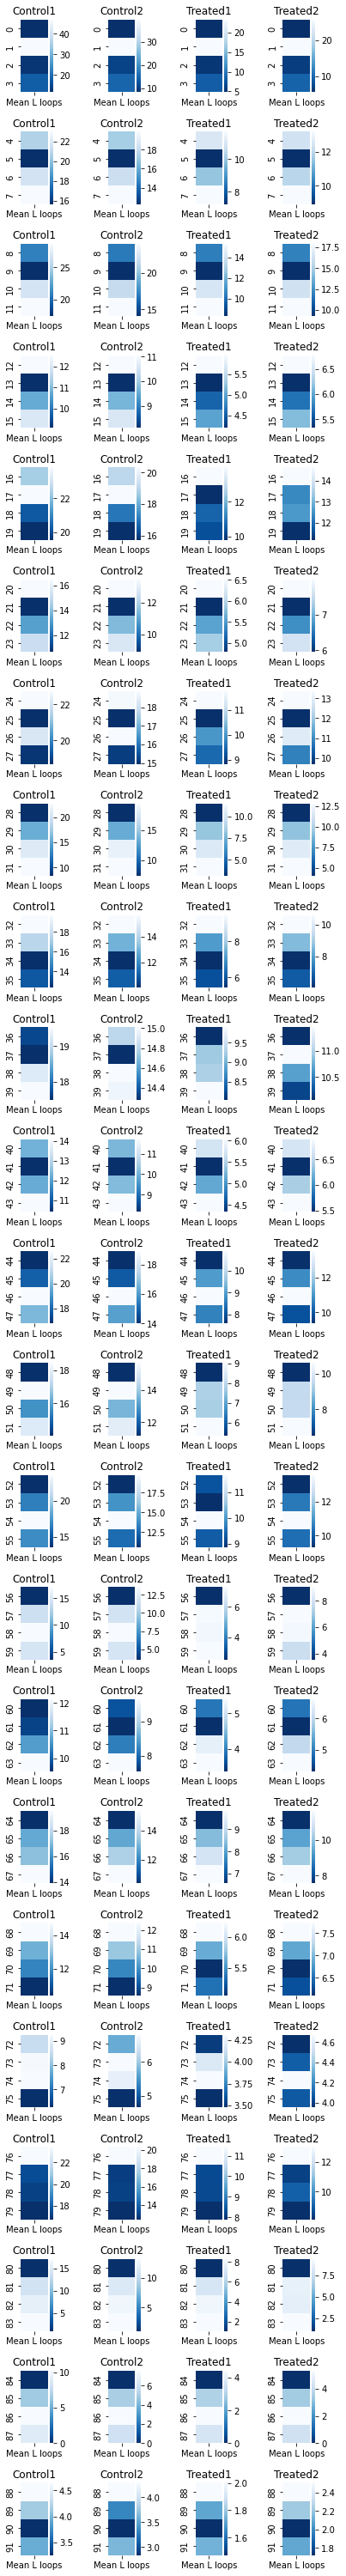

In [5]:
save_fig = False
path_figure = f'results counts/figures/{resolution}/segments'
width_figure=6
length_figure=42
fig, ax = plt.subplots(nrows= len(chromosomes), ncols=len(samples),figsize=(width_figure,length_figure))
fig.tight_layout(pad=2.5)
plot_quantity =  'Mean'


for i, sample in enumerate(samples):
    for j, chrom in enumerate(chromosomes):
        df_plot=df_tot[(df_tot['Sample']==sample) & (df_tot['Chr ID'] == chrom)]
        
        map_chr=df_plot[plot_quantity]
        df_seg={f'{plot_quantity} L loops': map_chr}
        df_seg=pd.DataFrame(data=df_seg)
    
        #i,j=np.unravel_index(t,(5,4))
        ax[j, i].set_title('{}'.format(sample))
        sns.heatmap(df_seg, cmap='Blues_r', ax = ax[j,i])  #vmin=0, vmax=df_tot[plot_quantity].max())
        #plt.tight_layout()
    
if save_fig:    
    save_figures(fig, path = path_figure, name_file = f'segments_{n_segments}_{thresh}', method= plot_quantity)


## SEGMENT ANALYSIS

In this segment we analyze the barcodes to find maxima and minima positions.

Load the dataset you want to analyse (pick resolution and number of segments)

In [64]:
resolution = 20
n_segments = 8
path_figure = f'results counts/figures/{resolution}/segments'
path_data = f'results counts/matrices/local matrices/{resolution}/{n_segments} segments/dataframe'
data = pd.read_csv(f'{path_data}/Segments.csv')
data

,Unnamed: 0,length,n contacts,Mean,Sum,Chr ID,Segment,Sample
0,0,[2. 2. 4. ... 3. 1. 1.],4515,6.898175,30621.0,1,0,Control1
1,1,[2. 2. 4. ... 3. 1. 1.],5083,6.340548,31931.0,1,1,Control1
2,2,[1. 1. 2. ... 3. 1. 1.],6995,15.772864,109858.0,1,2,Control1
3,3,[5. 5. 9. ... 3. 1. 1.],5857,19.416782,112695.0,1,3,Control1
4,4,[5. 5. 6. ... 1. 1. 1.],1286,7.743651,9757.0,1,4,Control1
...,...,...,...,...,...,...,...,...
731,179,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 4. 1. 1. ...,736,1.215933,580.0,X,3,Treated2
732,180,[2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. ...,923,1.130094,721.0,X,4,Treated2
733,181,[1. 3. 3. ... 1. 1. 1.],1288,1.338916,1359.0,X,5,Treated2
734,182,[ 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1230,1.413607,1309.0,X,6,Treated2


We want to see the differences in local distribution between control and treated samples. But, we have two control and two treated samples, so we will average them to have only one control and one sample signal

In [65]:
df_control1 = data[data['Sample'] == 'Control1']
df_control2 = data[data['Sample'] == 'Control2']

df_treated1 =  data[data['Sample'] == 'Treated1']
df_treated2 =  data[data['Sample'] == 'Treated2']

Making a new dataframe containing Mean and Sum of L patterns for both control and treated samples

In [66]:
mean_control = (np.array(df_control2['Mean']) + np.array(df_control1['Mean']))/2
sum_control = (np.array(df_control2['Sum']) + np.array(df_control1['Sum']))/2

df_control = {'Mean': mean_control, 'Sum': sum_control, 'Chr ID': df_control2['Chr ID'], 'Segment': df_control2['Segment'],
              'Sample': ['Control']*len(df_control2)}
df_control = pd.DataFrame(df_control)

mean_treated = (np.array(df_treated1['Mean']) + np.array(df_treated2['Mean']))/2
sum_treated = (np.array(df_treated1['Sum']) + np.array(df_treated2['Sum']))/2

df_treated = {'Mean': mean_treated, 'Sum': sum_treated, 'Chr ID': df_treated2['Chr ID'], 'Segment': df_treated2['Segment'],
              'Sample': ['Treated']*len(df_treated2)}
df_treated = pd.DataFrame(df_treated)

frames = [df_control, df_treated]
all_data = pd.concat(frames)

Plot the length of the L-patterns in both control and treated samples. Select the parameter you want to plot: 'Sum' or 'Mean'.

### Boxplot L-pattern size

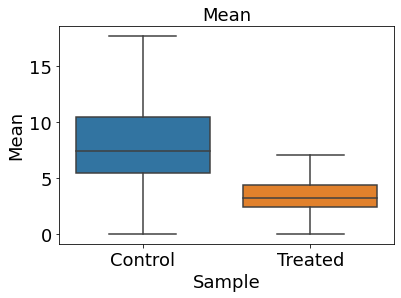

In [75]:
savefig = True
parameter = 'Mean'
set_layout(18, 18, 18)

fig = plt.figure()
plt.title(parameter)
sns.boxplot(y = parameter, x = 'Sample', data = all_data, showfliers = False)

if savefig:
    save_figures(fig, path = path_figure, name_file = 'L_pattern_size_boxplot', method= parameter)

### Histogram L-pattern size

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


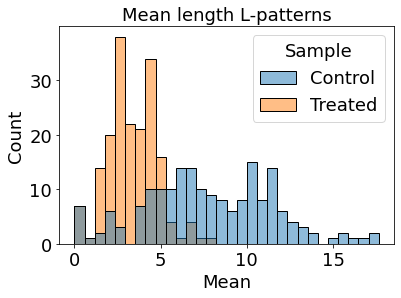

In [77]:
fig = plt.figure()
parameter = 'Mean'
plt.title(f'{parameter} length L-patterns')
sns.histplot( x = parameter, data = all_data, hue = 'Sample', bins = 30)

if savefig:
    save_figures(fig, path = path_figure, name_file = 'L_pattern_size_histo', method= parameter)

## Maxima and Minima
We make now a new dataframe containing the position (number of segment) of Maxima and Minima in the L pattern distribution.

In [69]:
samples = ['Control', 'Treated']
len_index=n_chromosomes*len(samples)
min_array=np.zeros(len_index, dtype = int)
max_array=np.zeros(len_index, dtype = int)
chrom_array=['']*len_index
sample_array=['']*len_index
min_array_sum= np.zeros(len_index, dtype = int)
max_array_sum= np.zeros(len_index, dtype = int)
#max_label_array= np.zeros(len_index)


index=0
for sample in samples:
    for chrom in chromosomes:
        df_chr=all_data[(all_data['Chr ID']== chrom) & (all_data['Sample']== sample)]
        
        #MEAN

        max_mean=df_chr['Mean'].max()
        max_pos=df_chr['Segment'][df_chr['Mean']==max_mean]
        
        min_mean=df_chr['Mean'].min()
        min_pos=df_chr['Segment'][df_chr['Mean']==min_mean]
        min_array[index]=int(min_pos.array[0])+1
        max_array[index]=int(max_pos.array[0])+1
        chrom_array[index]= chrom
        sample_array[index]= sample
        
        #SUM
        
        max_sum=df_chr['Sum'].max()
        max_pos=df_chr['Segment'][df_chr['Sum']==max_sum]
        min_sum=df_chr['Sum'].min()
        min_pos=df_chr['Segment'][df_chr['Sum']==min_sum]
        min_array_sum[index]=int(min_pos.array[0])+1
        max_array_sum[index]=int(max_pos.array[0])+1
              
        index=index+1         

#Store data in dataframe
df_comparison={'Chr ID': chrom_array, 'Sample': sample_array, 'Mean Minima': min_array, 'Mean Maxima': max_array, 
              'Sum Minima':min_array_sum, 'Sum Maxima':max_array_sum}

df_comp=pd.DataFrame(data=df_comparison)

Now we plot the position of local maxima and minima. Pick the parameter you want to plot:
- method = 'Mean Maxima'/'Mean Minima'/'Sum Maxima'/'Sum Minima'

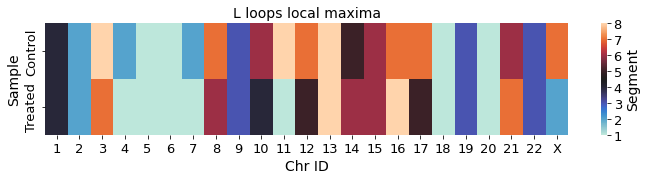

In [70]:
savefig = False
set_layout()
dataframe = df_comp
method = 'Mean Maxima'
name_file=f'L loops comparison {n_segments}'

df_heatmap=CreateDf_SegmentComparison(df_comp, method = method)
plot, col= Plot_SegmentComparison(df_heatmap, segments = np.arange(1, n_segments+1, 1))

if savefig:
    save_figures(plot, path_figure, name_file, method)

Find those chromosomes whose maxima (or minima) change position significantly and move to the other half of the chromosome:

In [71]:
parameter = 'Mean Minima'
half_segments = int(n_segments/2)
chromosomes = df_comp['Chr ID'].unique()
chr_shift = []


for chrom in chromosomes:
    df_chrom = df_comp[df_comp['Chr ID'] == chrom]
    
    pos_control = int(df_chrom[df_chrom['Sample'] == 'Control'][parameter])
    
    pos_treated =int(df_chrom[df_chrom['Sample'] == 'Treated'][parameter])
    
    if (pos_control <= half_segments and pos_treated > half_segments):
        chr_shift.append(chrom)
    elif (pos_control > half_segments and pos_treated <= half_segments):
        chr_shift.append(chrom)
    else:
        continue
        
print(chr_shift)

['2', '5', '17']


## Local variation barcodes
We calculate the average difference in L-pattern length between the control and the curaxin sample, for each chromosome segment. We plot the difference as barcodes (heatmaps)

In [72]:
mean_shift = np.array(df_control['Mean']) - np.array(df_treated['Mean'])
sum_shift = np.array(df_control['Sum']) - np.array(df_treated['Sum'])

df_shift = {'Delta Mean': mean_shift, 'Delta Sum': sum_shift, 'Chr ID': df_control['Chr ID'], 'Segment': df_control['Segment']}
df_shift = pd.DataFrame(df_shift)
df_shift

,Delta Mean,Delta Sum,Chr ID,Segment
184,3.489325,19236.0,1,0
185,3.263199,20862.5,1,1
186,8.574826,73936.5,1,2
187,9.602487,68834.5,1,3
188,3.361967,5881.5,1,4
...,...,...,...,...
363,0.808402,1187.0,X,3
364,0.228093,472.0,X,4
365,0.846165,1827.5,X,5
366,1.201106,2320.5,X,6


Plot the barcodes. Pick the heatmap color boundaries (vis_min, vis_max) to optimize visualization

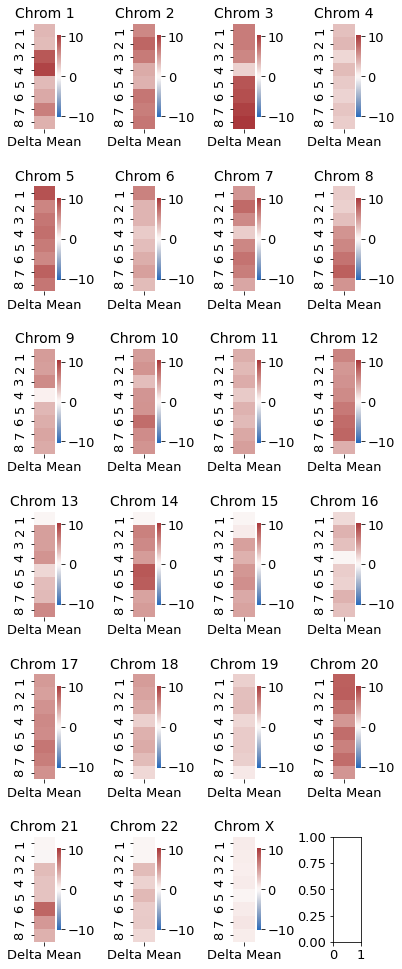

In [73]:
savefig = False
set_layout()
vis_min = -df_shift[plot_quantity].max()
vis_max =  df_shift[plot_quantity].max()
width_figure=6
length_figure=14

plot_quantity = 'Delta Mean'
fig, ax = plt.subplots(nrows= 6, ncols= 4,figsize=(width_figure,length_figure))
fig.tight_layout(pad=2.5)

for t, chrom in enumerate(chromosomes):
    df_plot=df_shift[df_shift['Chr ID'] == chrom]
        
    map_chr=df_plot[plot_quantity]
    df_seg={f'{plot_quantity}': map_chr}
    df_seg=pd.DataFrame(data=df_seg)
    ylabels = np.arange(1,n_segments + 1, 1)
    
    i,j=np.unravel_index(t,(6,4))
    ax[i, j].set_title(f'Chrom {chrom}')
    cmap = sns.color_palette("vlag", as_cmap=True)
    #plt.figure()
    sns.heatmap(df_seg, cmap= cmap, vmin = vis_min, vmax = vis_max,
                yticklabels= ylabels, ax = ax[i,j])
    

if savefig:
    save_figures(fig, path_figure, name_file = f'barcode_{n_segments}', method = plot_quantity)